In [120]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
import time
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [121]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [122]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [123]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

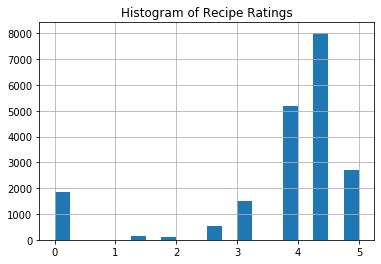

In [124]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [125]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [126]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

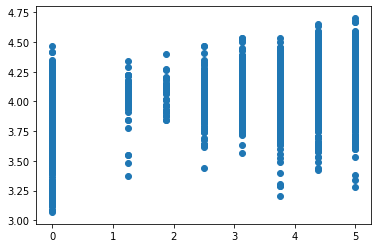

In [127]:
plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinuous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [128]:
svr.score(X, Y)

-0.003978314483867873

In [129]:
from sklearn.model_selection import cross_val_score
start = time.time()
scores = cross_val_score(svr, X, Y, cv=5)
print('{} seconds'.format(time.time()-start))
print(scores)

100.88104319572449 seconds
[-0.01787926 -0.02916288 -0.02841122 -0.03767394 -0.01735362]


Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

In [130]:
rating_corr = raw_data.corr()['rating']

In [131]:
rating_corr.nlargest(16)

rating            1.000000
bon appétit       0.124549
peanut free       0.096087
soy free          0.092965
tree nut free     0.081347
bake              0.076978
roast             0.073499
fall              0.067343
sauté             0.066553
dinner            0.060957
kosher            0.059071
winter            0.055126
pescatarian       0.054034
thanksgiving      0.052990
onion             0.049997
grill/barbecue    0.048081
Name: rating, dtype: float64

In [132]:
rating_corr.nsmallest(15)

drink            -0.241388
alcoholic        -0.224767
house & garden   -0.217911
gin              -0.191400
spirit           -0.146625
cocktail         -0.140723
cocktail party   -0.140482
bitters          -0.137368
harpercollins    -0.105094
liqueur          -0.090757
rum              -0.084689
non-alcoholic    -0.077476
condiment        -0.076295
brandy           -0.065481
fortified wine   -0.063814
Name: rating, dtype: float64

Interestingly, it seems like most of our indicators of high ratings are seasonal meals, or allergen-free recipes. Almost all of our indicators of low ratings have to do with alcohol.

In [133]:
rating_corr['calories']

0.007881639551024439

In [134]:
rating_corr['protein']

0.013979849517210067

In [135]:
rating_corr['fat']

0.007235710276950674

In [136]:
rating_corr['sodium']

0.008176803223553204

Kind of surprising that these correlations are so low. It's also not promising for our ability to build a predictive model with only 30 factors, as the rest are dummy variables that only apply to a few recipes each. Let's see if we can clean the data a little and produce a better result.

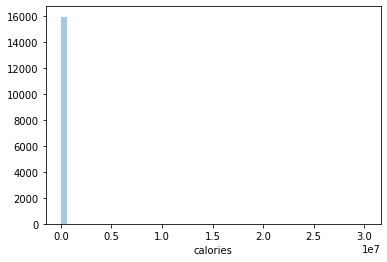

In [137]:
sns.distplot(raw_data['calories'].dropna(), kde=False)

In [138]:
raw_data = raw_data[raw_data.calories < 50000]

In [139]:
raw_data[raw_data.protein > 500]

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
1465,Manhattan Clam Chowder,4.375,9811.0,1625.0,128.0,67615.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2187,Sea Scallops with Ham-Braised Cabbage and Kale,5.000,3801.0,626.0,42.0,20492.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2427,Sea Scallops with Ham-Braised Cabbage and Kale,5.000,3801.0,626.0,42.0,20492.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3280,Braised Short Ribs with Red Wine Gravy,3.750,19576.0,723.0,1818.0,2950.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3295,Clam and Oyster Chowder,5.000,8406.0,1365.0,113.0,55369.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4482,Tamarind-Honey Lamb Kebabs on Mashed Yams,4.375,9831.0,840.0,666.0,2624.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6645,Braised Orange-Ginger Short Ribs with Dried Ap...,4.375,16050.0,592.0,1480.0,2629.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7471,Bass with Herbed Rice and Coconut-Vegetable Ch...,5.000,5474.0,898.0,150.0,4094.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7724,"Braised Chicken With Asparagus, Peas, and Melt...",3.750,8275.0,608.0,618.0,4011.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8192,Grilled Lamb Chops with Porcini Mustard,5.000,24117.0,940.0,2228.0,4382.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


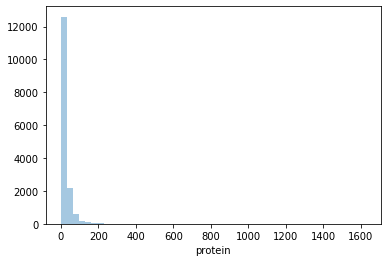

In [140]:
sns.distplot(raw_data.protein.dropna(), kde=False)

In [141]:
raw_data = raw_data[raw_data.protein < 500]

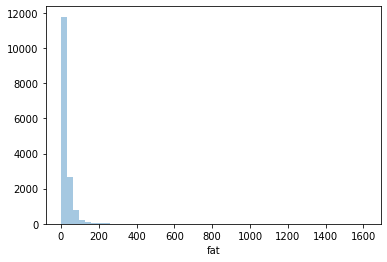

In [142]:
sns.distplot(raw_data.fat.dropna(), kde=False)

In [143]:
raw_data = raw_data[raw_data.fat < 500]

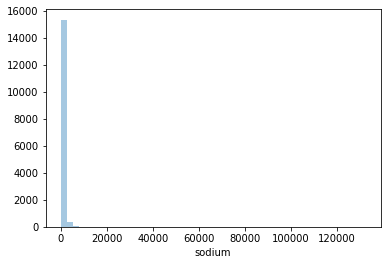

In [144]:
sns.distplot(raw_data.sodium.dropna(), kde=False)

In [145]:
raw_data = raw_data[raw_data.sodium < 20000]

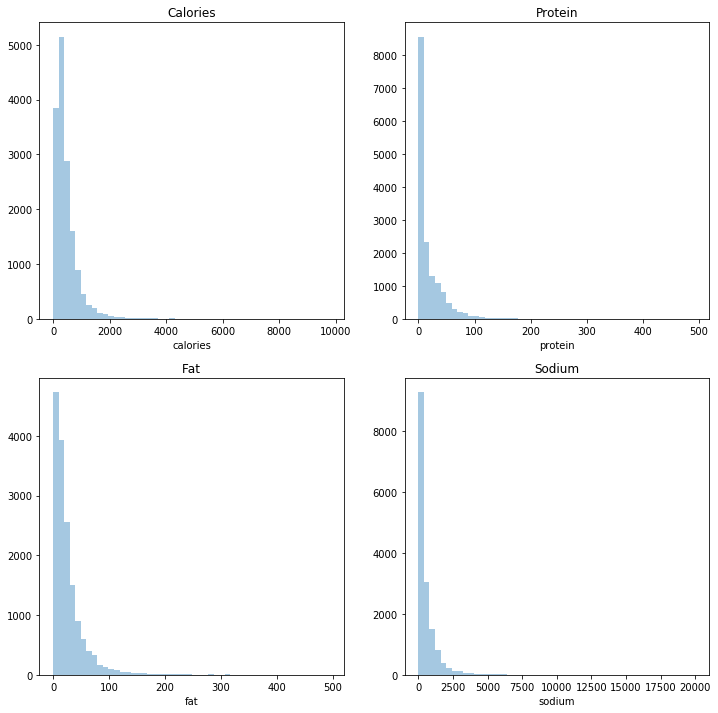

In [146]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
sns.distplot(raw_data.calories.dropna(), kde=False)
plt.title('Calories')

plt.subplot(2,2,2)
sns.distplot(raw_data.protein.dropna(), kde=False)
plt.title('Protein')

plt.subplot(2,2,3)
sns.distplot(raw_data.fat.dropna(), kde=False)
plt.title('Fat')

plt.subplot(2,2,4)
sns.distplot(raw_data.sodium.dropna(), kde=False)
plt.title('Sodium')

plt.show()

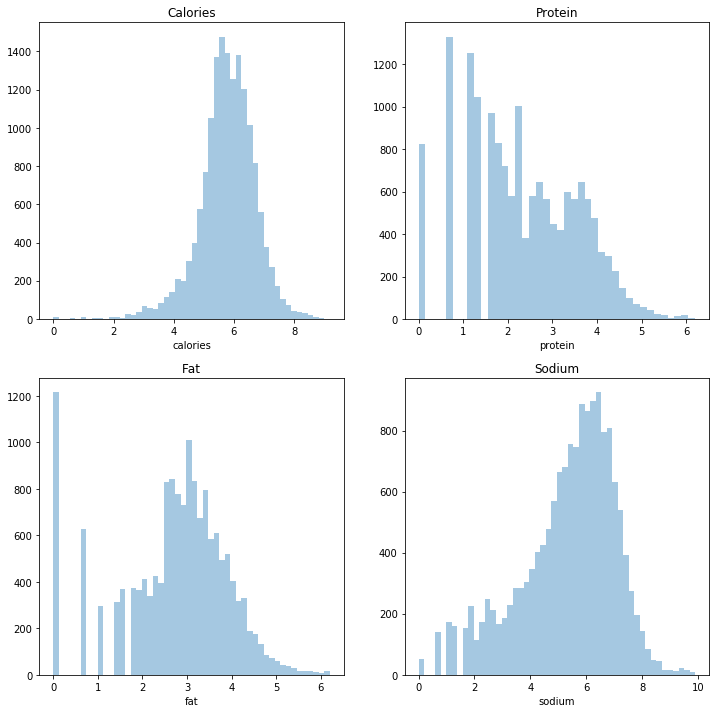

In [147]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
sns.distplot(np.log(raw_data.calories.dropna()+1), kde=False)
plt.title('Calories')

plt.subplot(2,2,2)
sns.distplot(np.log(raw_data.protein.dropna()+1), kde=False)
plt.title('Protein')

plt.subplot(2,2,3)
sns.distplot(np.log(raw_data.fat.dropna()+1), kde=False)
plt.title('Fat')

plt.subplot(2,2,4)
sns.distplot(np.log(raw_data.sodium.dropna()+1), kde=False)
plt.title('Sodium')

plt.show()

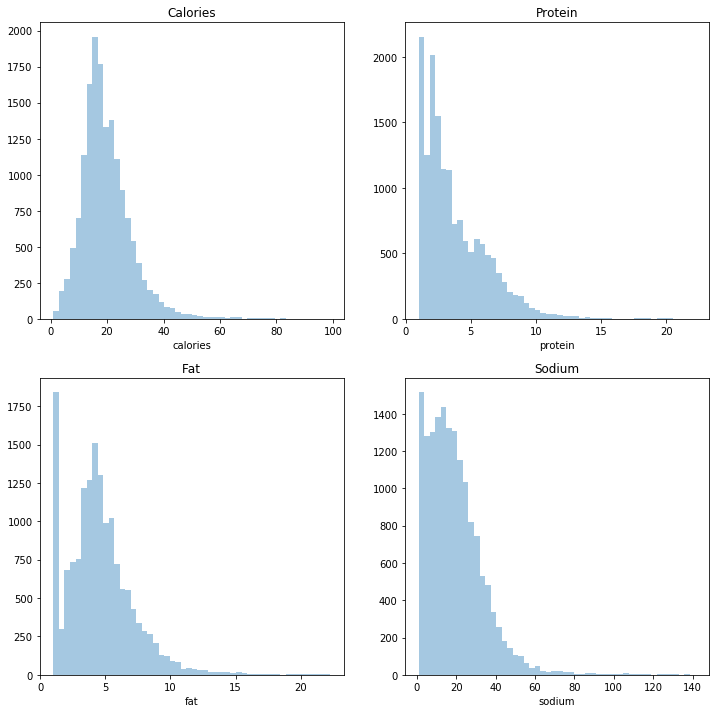

In [148]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
sns.distplot(np.sqrt(raw_data.calories.dropna()+1), kde=False)
plt.title('Calories')

plt.subplot(2,2,2)
sns.distplot(np.sqrt(raw_data.protein.dropna()+1), kde=False)
plt.title('Protein')

plt.subplot(2,2,3)
sns.distplot(np.sqrt(raw_data.fat.dropna()+1), kde=False)
plt.title('Fat')

plt.subplot(2,2,4)
sns.distplot(np.sqrt(raw_data.sodium.dropna()+1), kde=False)
plt.title('Sodium')

plt.show()

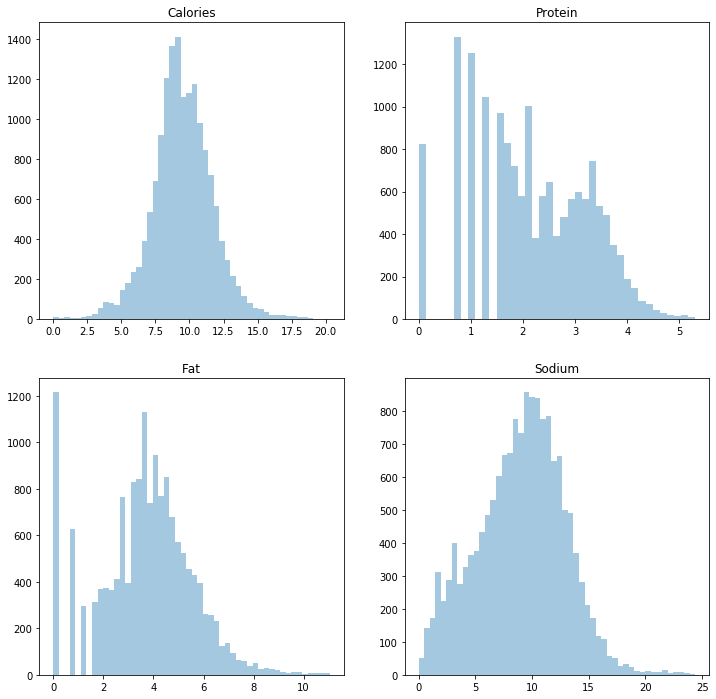

In [149]:


plt.figure(figsize=(12,12))

plt.subplot(2,2,1)

bc,_ = boxcox(raw_data.calories.dropna()+1)
sns.distplot(bc, kde=False)
plt.title('Calories')

plt.subplot(2,2,2)
bc,_ = boxcox(raw_data.protein.dropna()+1)
sns.distplot(bc, kde=False)
plt.title('Protein')

plt.subplot(2,2,3)
bc,_ = boxcox(raw_data.fat.dropna()+1)
sns.distplot(bc, kde=False)
plt.title('Fat')

plt.subplot(2,2,4)
bc,_ = boxcox(raw_data.sodium.dropna()+1)
sns.distplot(bc, kde=False)
plt.title('Sodium')

plt.show()

In [150]:
raw_data.fillna(raw_data.mean(), inplace=True)

In [151]:
raw_data['calories'],_ = boxcox(raw_data['calories']+1)
raw_data['protein'],_ = boxcox(raw_data['protein']+1)
raw_data['fat'],_ = boxcox(raw_data['fat']+1)
raw_data['sodium'],_ = boxcox(raw_data['sodium']+1)

In [152]:
rating_corr = raw_data.corr()['rating']

In [153]:
rating_corr.nlargest(16)

rating            1.000000
fat               0.191161
protein           0.188137
sodium            0.152386
calories          0.143143
bon appétit       0.130121
peanut free       0.078696
soy free          0.078027
roast             0.071381
bake              0.070562
tree nut free     0.069773
fall              0.065536
sauté             0.061131
thanksgiving      0.060925
winter            0.057249
grill/barbecue    0.049814
Name: rating, dtype: float64

Pretty crazy. After normalizing our numerical values, they jump to the top of the list of factors correlated with our target.

In [154]:
factors = rating_corr.nlargest(16).index[1:]
factors = factors.append(rating_corr.nsmallest(15).index)


In [155]:
X = raw_data[factors]
Y = raw_data['rating']

start = time.time()
scores = cross_val_score(svr, X, Y, cv=5)
print('{} seconds'.format(time.time()-start))
print(scores)

51.31092286109924 seconds
[0.02713108 0.04256581 0.03989339 0.05691222 0.03839469]


This is still pretty low but substantially better than the initial model. Additionally, it runs in about half the time.

Let's try running it again as a classifier. We'll use a boolean variable equal to 1 if the rating is above a 4 as our target.

In [166]:
from sklearn import svm

Y = pd.Series(raw_data['rating'] >= 4)
clf = svm.SVC()
start = time.time()
scores = cross_val_score(clf, X, Y, cv=5)
print('{} seconds'.format(time.time()-start))
print(scores)

63.324320793151855 seconds
[0.57346422 0.57979734 0.57631412 0.58093126 0.58523447]


Took a little longer to run. Our r-squared is substantially higher, but I'm not 100% sure how to compare the two, sicne one was a classifier and one was a regression. Either way, this seems promising.